In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch

# Custom modules
from agent import *
from approximators import *
from utils import *


SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
bounds = sa_bounds

# approximator = TilingApproximatorMedium(
#     bounds = bounds,
#     n_tiles = 16,
#     n_tilings = 128,
#     shifts = np.random.uniform(0.08, 0.13, size=len(bounds)),
# )

approximator = NeuralNet(
    input_dim = 30,
    n_epochs = 1,
    device = device,
)

In [3]:
# env = gym.make('Pusher-v5', render_mode='human')
env = gym.make('Pusher-v5')
agent = QLearningAgent(
    env = env,
    discount_factor = 0.995,
    initial_epsilon = 0.7,
    epsilon_decay = 0.99,
    min_epsilon = 0.0,
    q_value_approximator = approximator,
    seed = SEED
)

In [4]:
n_episodes = 100
horizon = 210
buffer = []
actions_buffer = []
losses = []    
buffer_size = 70

rewards = np.zeros((n_episodes, horizon))

progress_bar = tqdm(range(n_episodes), desc='Training')
for episode in progress_bar:
    state, _ = env.reset()

    episode_losses = []
    
    for t in range(horizon):
        # Use behavior policy to select action
        action = agent.behaviour_policy(state)
        sa_couple = np.concatenate([state, action])

        # Take action and observe next state and reward
        next_state, reward, done, _, _ = env.step(action)
        if done:
            break
        rewards[episode, t] = reward

        # Compute the best action for the next state
        next_action = agent.target_policy(next_state)
        next_sa_couple = np.concatenate([next_state, next_action])

        # Compute the target
        target = reward + agent.discount_factor * agent.q_value_approximator.predict(next_sa_couple)

        # Update the Q-value approximator
        if len(buffer) < buffer_size:
            buffer.append((sa_couple, target))
            actions_buffer.append(next_action)
        else:
            X, y = zip(*buffer)
            loss = agent.q_value_approximator.update(X, y)
            buffer = []
            episode_losses.append(loss)
            # Update the action space model
            agent.action_space_model.fit(actions_buffer)
            actions_buffer = []

        # Update state
        state = next_state
    
    # Save the losses for this episode
    losses.append(episode_losses)

    # Update epsilon
    agent.update_epsilon()

    progress_bar.set_postfix({
        'episode': episode,
        'reward': np.mean(rewards[episode]),
        'epsilon': agent.epsilon,
        'loss': np.mean(losses[-1][-5:]),
    })

Training:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

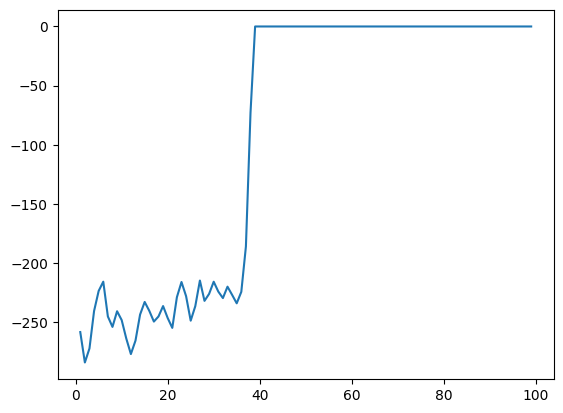

In [5]:
rewards_cumsum = pd.Series(rewards.cumsum(axis=1)[:, -1])

plt.plot(rewards_cumsum.rolling(2).mean())

DataError: No numeric types to aggregate

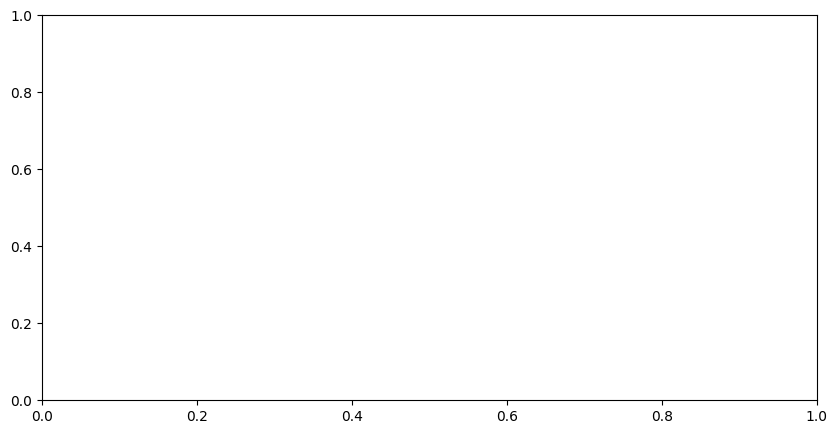

In [6]:
losses = pd.Series(losses)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(losses.rolling(8000).mean())
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
# ax.set_yscale('log')
plt.show()

In [ ]:
# play and episode and render
state, _ = env.reset()
done = False
while not done:
    env.render()
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state

env.close()